In [41]:
import nltk
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('reuters')
from nltk.corpus import reuters

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from nltk.classify import NaiveBayesClassifier
import random

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/eilonzohar/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [21]:
file_ids = reuters.fileids ()
Categories = reuters.categories ()

## 1. Text Classification

In [22]:
categories = ['crude', 'grain']
documents = [(reuters.words(fileid), category)
             for category in categories
             for fileid in reuters.fileids(category)]

random.shuffle(documents)

In [54]:
# Prepare data for 'crude' and 'grain' categories
categories = ['crude', 'grain']
documents = [(reuters.words(fileid), category)
             for category in categories
             for fileid in reuters.fileids(category)] # Every element (document) is  [[word1, word2, ....], category]

random.shuffle(documents)

# Feature extraction
def document_features(document_words_as_array, word_features):
    document_words_as_set = set(document_words_as_array)
    features = {}
    for word in word_features:
        features[f'contains({word})'] = (word in document_words_as_set)
    return features

# Feature selection
all_words = nltk.FreqDist(w.lower() for w in reuters.words(categories=categories))
word_features = list(all_words)[:2000]

# Training classifier
featuresets = [(document_features(doc, word_features), cat) for (doc, cat) in documents] # cat = category, doc = document
# word features are the 2000 most popular words in all of reuters headlines, 
# document_features takes each of them and checks if it is said in the headline (doc)

train_size_rel = 0.75 # train on 75% of the data
train_size_actual = int (train_size_rel * len (documents))
train_set, test_set = featuresets[:train_size_actual], featuresets[train_size_actual:]
classifier = NaiveBayesClassifier.train(train_set)

# Evaluate classifier
print("Accuracy:", np.round(nltk.classify.accuracy(classifier, test_set), 3))
classifier.show_most_informative_features(10)


Accuracy: 0.89
Most Informative Features
         contains(wheat) = True            grain : crude  =    135.1 : 1.0
             contains(;) = True            crude : grain  =     90.9 : 1.0
          contains(corn) = True            grain : crude  =     70.0 : 1.0
         contains(crude) = True            crude : grain  =     50.0 : 1.0
     contains(petroleum) = True            crude : grain  =     28.1 : 1.0
      contains(drilling) = True            crude : grain  =     24.0 : 1.0
        contains(energy) = True            crude : grain  =     20.9 : 1.0
       contains(soybean) = True            grain : crude  =     20.7 : 1.0
           contains(oil) = True            crude : grain  =     18.8 : 1.0
       contains(farmers) = True            grain : crude  =     18.2 : 1.0


In [55]:
# Around 0.9 accuracy and most informative features aren't so informative. 
# Lets try that again after removing stop words
stop_words = set(stopwords.words('english'))

# Prepare data for 'crude' and 'grain' categories
categories = ['crude', 'grain']
documents = [(reuters.words(fileid), category)
             for category in categories
             for fileid in reuters.fileids(category)] # Every element (document) is  [[word1, word2, ....], category]

random.shuffle(documents)

# Feature extraction
def document_features(document_words_as_array, word_features):
    # New addition {
     
    words = word_tokenize(" ".join (document_words_as_array))
    words = [word for word in words if word.isalnum() and word.lower() not in stop_words] 
    
    # } 
    document_words_as_set = set(words)
    features = {}
    for word in word_features:
        features[f'contains({word})'] = (word in document_words_as_set)
    return features

# Feature selection
all_words = nltk.FreqDist(w.lower() for w in reuters.words(categories=categories))
word_features = list(all_words)[:2000]

# Training classifier
featuresets = [(document_features(doc, word_features), cat) for (doc, cat) in documents] # cat = category, doc = document
# word features are the 2000 most popular words in all of reuters headlines, 
# document_features takes each of them and checks if it is said in the headline (doc)

train_size_rel = 0.75 # train on 75% of the data
train_size_actual = int (train_size_rel * len (documents))
train_set, test_set = featuresets[:train_size_actual], featuresets[train_size_actual:]
classifier = NaiveBayesClassifier.train(train_set)

# Evaluate classifier
print("Accuracy:", np.round(nltk.classify.accuracy(classifier, test_set), 3))
classifier.show_most_informative_features(10)

Accuracy: 0.914
Most Informative Features
         contains(wheat) = True            grain : crude  =    128.9 : 1.0
         contains(grain) = True            grain : crude  =     97.4 : 1.0
            contains(lt) = True            crude : grain  =     86.6 : 1.0
          contains(corn) = True            grain : crude  =     69.3 : 1.0
         contains(crude) = True            crude : grain  =     39.5 : 1.0
        contains(energy) = True            crude : grain  =     33.5 : 1.0
       contains(natural) = True            crude : grain  =     24.9 : 1.0
           contains(oil) = True            crude : grain  =     21.9 : 1.0
      contains(drilling) = True            crude : grain  =     20.9 : 1.0
       contains(soybean) = True            grain : crude  =     20.4 : 1.0


### (-8

## 2. Topic Modeling - "grain"

In [71]:
# Filter texts to match one category
category = "grain"
category_docs = reuters.fileids (category)

# Doc 2 text
texts = [reuters.raw(doc_id) for doc_id in category_docs]

# Tokenize, remove stop words, and apply stemming and lemmatization
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    words = word_tokenize(text)
    words = [word for word in words if word.isalnum() and word.lower() not in stop_words]
    stemmed = [stemmer.stem(word) for word in words]
    lemmatized = [lemmatizer.lemmatize(word) for word in words]
    return stemmed, lemmatized

processed_texts = [preprocess(text) for text in texts]

In [72]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Prepare lemmatized text data
texts = [" ".join(lemmatized_text) for stemmed_text, lemmatized_text in processed_texts]

# Vectorize the text
vectorizer = CountVectorizer(max_df= 0.95, min_df= 2, stop_words='english') # ignore tokens that appear in more than 95%, ignore tokens that appear in less than 2 documents
dtm = vectorizer.fit_transform(texts)

# Apply LDA - understand topic. for example - if the words purple, yellow and green are mentioned a lot - lda will tell us we speak about colors
lda = LatentDirichletAllocation(n_components= 5) # 5 topics
lda.fit(dtm)

# Display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 5
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)


Topic 0:
said farm year trade wheat
Topic 1:
said nil wheat grain crop
Topic 2:
tonne mln wheat said export
Topic 3:
said grain dlrs certificate corn
Topic 4:
corn said price mln usda


## 3. Sentiment Analysis - "crude"

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/eilonzohar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


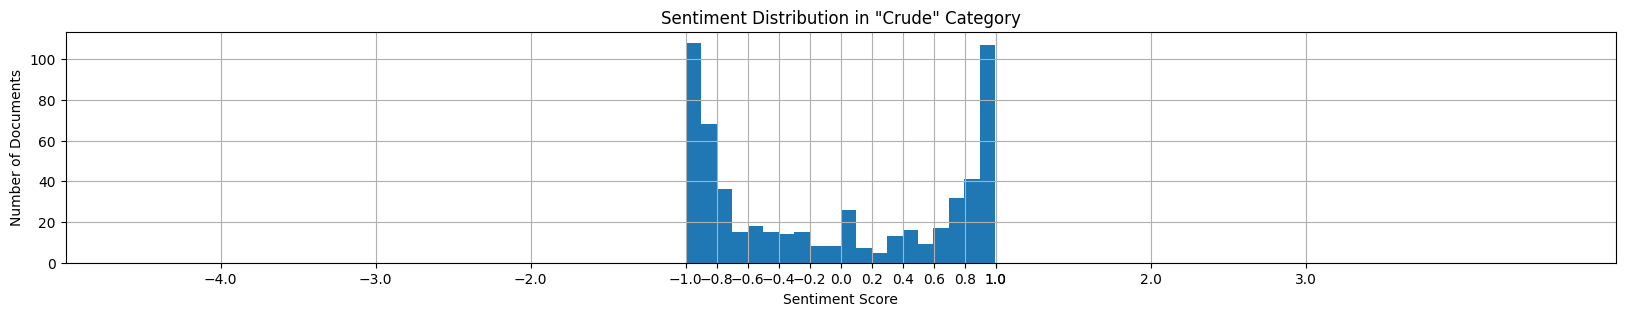

In [88]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

nltk.download('vader_lexicon') # http://eegilbert.org/papers/icwsm14.vader.hutto.pdf

category = "crude"
category_docs = reuters.fileids (category)

# Doc 2 text
texts = [reuters.raw(doc_id) for doc_id in category_docs]

# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Perform sentiment analysis
sentiments = [sid.polarity_scores (text)['compound'] for text in texts]

# Visualize sentiment distribution
plt.figure (figsize= (20, 3))
plt.hist (sentiments, bins=20)
plt.title ('Sentiment Distribution in "Crude" Category')
plt.xlabel ('Sentiment Score')
plt.ylabel ('Number of Documents')
plt.grid ()
plt.xlim (-5, 5)
plt.xticks ([-4 + j for j in range (3)] + [-1 + j/5 for j in range (11)] + [1 + j for j in range (3)])
plt.show ()

Texts that are catogerized as crude have a pretty neutral sentiment, which is expected from a stately website